In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
import itertools as it
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

/anaconda/envs/python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
os.chdir('/Users/syedrahman/Documents/Summer2017/Insight/breast-cancer-wisconsin')

In [3]:
bcw = pd.read_csv('breast-cancer-wisconsin.txt',header=None)

In [4]:
bcw = bcw.apply(pd.to_numeric,errors='coerce')

In [5]:
### checking if there are any null values
pd.isnull(bcw).apply(sum, axis = 0)

0      0
1      0
2      0
3      0
4      0
5      0
6     16
7      0
8      0
9      0
10     0
dtype: int64

In [6]:
bcw_drop = bcw.dropna(axis=0)
bcw_drop.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [7]:
Xcolumns = bcw_drop.columns[1:10]
ycolumns = bcw_drop.columns[10]
X = bcw_drop[Xcolumns].as_matrix()

In [8]:
### recoding malignant tumors as 1 
y = (bcw_drop[ycolumns]==4)*1.0
### dividing dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

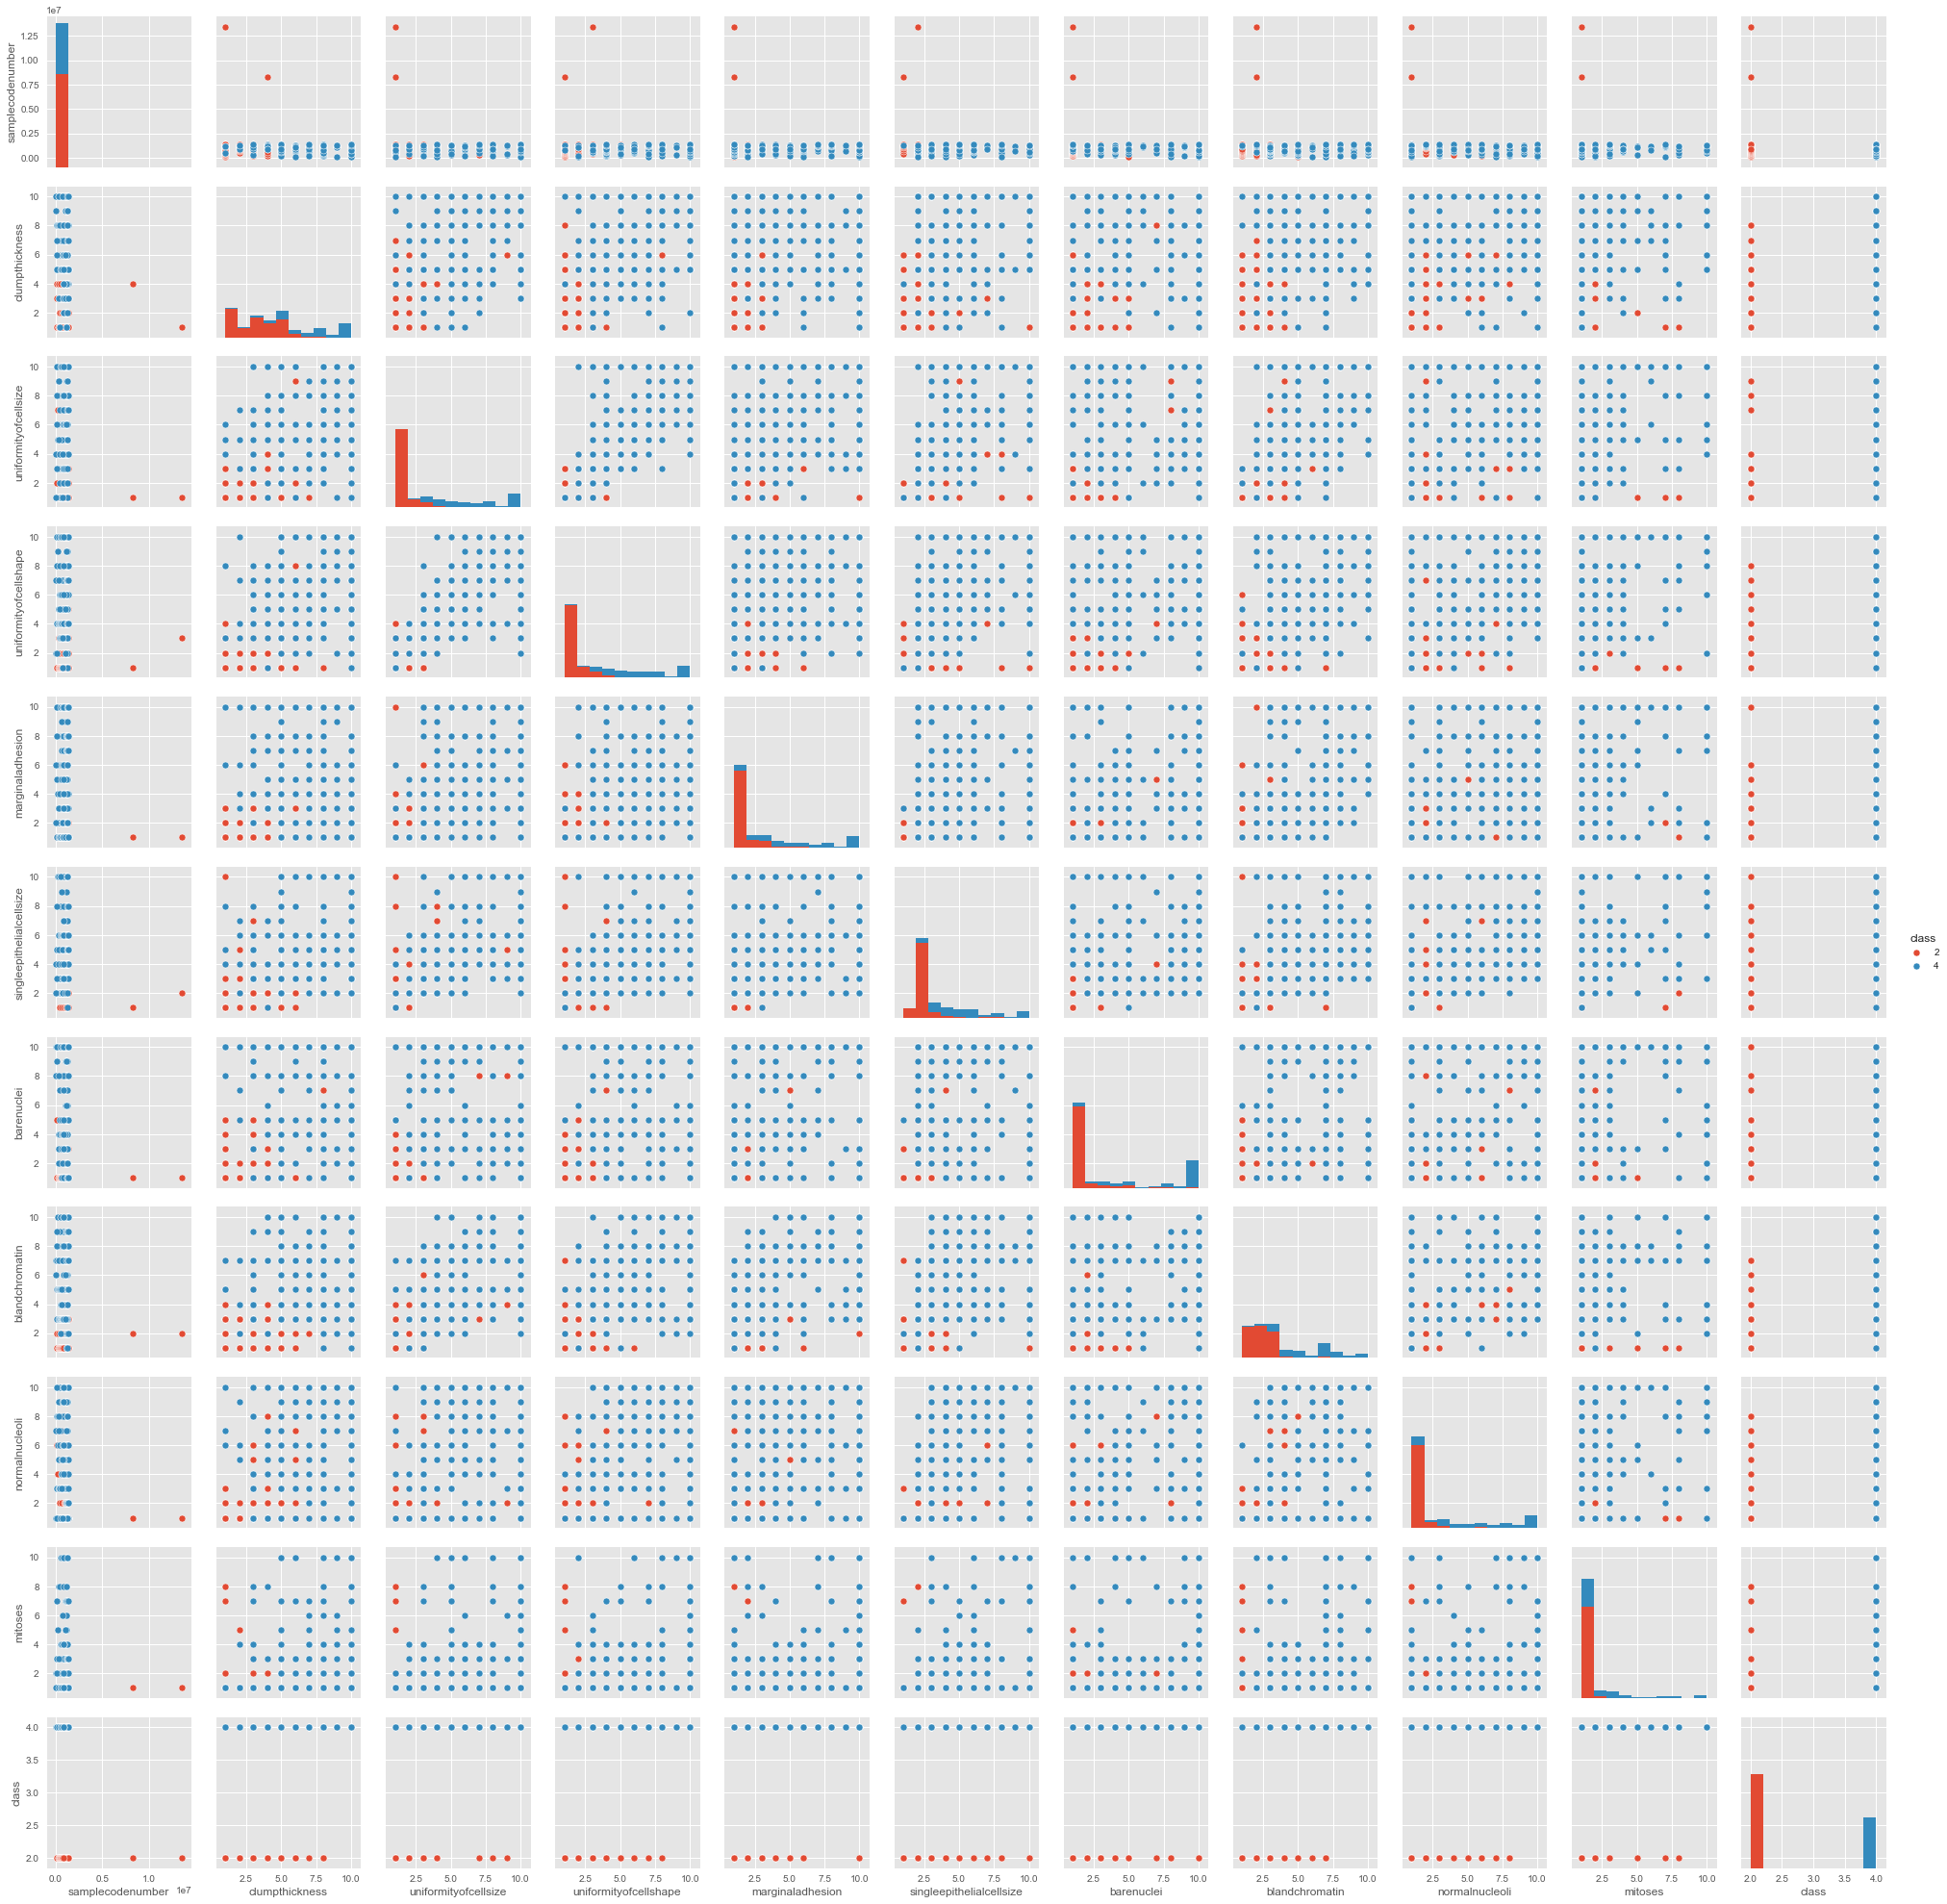

In [56]:
columns = ['Sample code number',
'Clump Thickness',
'Uniformity of Cell Size',
'Uniformity of Cell Shape',
'Marginal Adhesion',
'Single Epithelial Cell Size',
'Bare Nuclei',
'Bland Chromatin',
'Normal Nucleoli',
'Mitoses', 
'Class']
bcw_drop.columns = [x.lower().replace(' ', '') for x in columns]
sns.pairplot(bcw_drop, hue="class")

First we try a PCA to see what this looks like in a reduced space.

In [9]:
pca = PCA(n_components=2)
pcaU=pca.fit_transform(X)

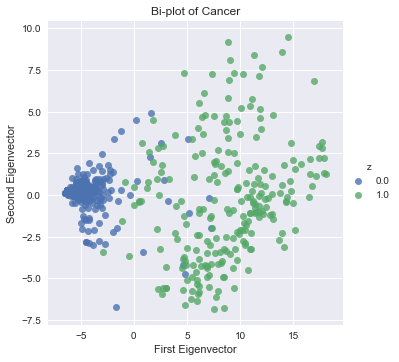

In [10]:
sns.lmplot('x', 'y',
           data=pd.DataFrame({'x':pcaU[:,0],'y':pcaU[:,1],'z':y}),
           fit_reg=False,
           hue="z")
plt.title('Bi-plot of Cancer')
plt.xlabel('First Eigenvector')
plt.ylabel('Second Eigenvector')

In [22]:
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression(penalty = 'l1')
logis.fit(X_train, y_train)
y_pred = logis.predict(X_test)
print f1_score(y_test,y_pred)
print accuracy_score(y_test,y_pred)
print recall_score(y_test,y_pred)
print precision_score(y_test,y_pred)

0.937062937063
0.956097560976
0.930555555556
0.943661971831


In [69]:
logis.coef_ 

array([[ 0.38838353,  0.22250905,  0.3634599 ,  0.08197934, -0.08384127,
         0.38079376,  0.25883822,  0.27450198,  0.22618281]])

Seems like all variables have an impact for logistic regression

In [18]:
from sklearn import svm

In [19]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print f1_score(y_test,y_pred)
print accuracy_score(y_test,y_pred)
print recall_score(y_test,y_pred)
print precision_score(y_test,y_pred)

0.96
0.970731707317
1.0
0.923076923077


The SVM does pretty well, although precision score is a bit low

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train).transform(X_train)
y_pred = lda.predict(X_test)
print f1_score(y_test,y_pred)
print accuracy_score(y_test,y_pred)
print recall_score(y_test,y_pred)
print precision_score(y_test,y_pred)

0.921985815603
0.946341463415
0.902777777778
0.942028985507


Try random forest on all possible combinations. This seems to work the best. Performs the best in terms of all the metrics. 

In [17]:
maxf1 = 0
for i in range(1,10):
    varCombs = list(it.combinations(range(0,9),i))
    for j in range(len(varCombs)):
        Xmat = X_train[:,varCombs[j]]
        X_train_CV, X_test_CV, y_train_CV, y_test_CV = train_test_split(Xmat, y_train, test_size=0.3, random_state=1)
        clf = RandomForestClassifier(n_jobs=2)
        clf.fit(X_train_CV, y_train_CV)
        y_pred = clf.predict(X_test_CV)
        if(f1_score(y_test_CV,y_pred)>maxf1):
            maxf1=f1_score(y_test_CV,y_pred)
            bestmodel = varCombs[j]
            bestfit = clf
            bestaccuracy = accuracy_score(y_test_CV,y_pred)
            bestrecall = recall_score(y_test_CV,y_pred)
            bestprecision = precision_score(y_test_CV,y_pred)

In [18]:
print bestmodel
print maxf1
print bestaccuracy
print bestrecall
print bestprecision

(0, 1, 3, 4, 5, 7)
0.990099009901
0.993055555556
0.980392156863
1.0


In [19]:
y_pred = bestfit.predict_proba(X_test[:,bestmodel])

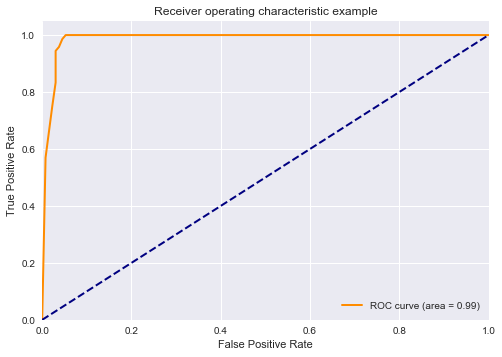

In [20]:
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred[:,1].ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Feature ranking:
1. feature 1 (0.405394)
2. feature 3 (0.279298)
3. feature 4 (0.201617)
4. feature 0 (0.078684)
5. feature 2 (0.035008)


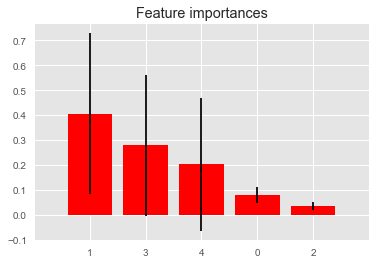

In [68]:
importances = bestfit.feature_importances_
std = np.std([tree.feature_importances_ for tree in bestfit.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X_test[:,bestmodel].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test[:,bestmodel].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test[:,bestmodel].shape[1]), indices)
plt.xlim([-1, X_test[:,bestmodel].shape[1]])
plt.show()

Features are ranked according to importance. 